In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

In [3]:
boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [4]:
s = StandardScaler()
data = s.fit_transform(data)

In [5]:
def forward_linear_regression(x_batch, y_batch, weights):
    '''
    Forward pass for the step by step linear regression
    '''
    
    # Assert training and testing data have the same size
    assert x_batch[0] == y_batch[0]
    
    # Assert matrix multiplication can work on x and w
    assert x_batch[1] == weights['W'].shape[0]
    
    # Assert that B is simply a 1x1 ndarry
    assert weights['B'].shape[0]==weights['B'].shape[1]==1
    
    N = np.dot(x_batch, weights['W'])
    P = N + weights['B']
    
    loss = np.mean(np.power((y_batch - P), 2))
    
    forward_info = {}
    forward_info['X'] = x_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return loss, forward_info

In [6]:
def init_weights(n_in):
    '''
    initialize weights on the forward pass
    '''
    
    weights = {}
    w = np.random.randn(n_in, 1)
    b = np.random.randn(1, 1)
    
    weights['W'] = w
    weights['B'] = b
    
    return weights

In [7]:
def generate_batch(x, y, start, batch_size):
    '''
    Generate a batch from x and y, given starting position
    '''
    
    assert x.ndim == y.ndim == 2
    
    
    # Remaining data that is not the length of batch_size
    if start + batch_size > x.shape[0]:
        batch_size = x.shape[0] - start
    
    x_batch = x[start:start+batch_size]
    y_batch = y[start:start+batch_size]
    
    return x_batch, y_batch

In [8]:
def permute_data(x, y):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    # X.shape[0] = number of oberservations
    perm = np.random.permutation(x.shape[0])
    
    return x[perm], y[perm]

In [9]:
def forward_loss(x, y, weights):
    '''
    Generate predictions and calculate loss for a step by step linear regression
    '''
    
    N = np.dot(x, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y - P, 2))
    
    forward_info = {}
    forward_info['X'] = x
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y
    
    return forward_info, loss

In [10]:
def loss_gradient(forward_info, weights):
    # P = np.dot(x, w) + B
    
    # dL_dW = dL_dP * dP_dN * dN_dW
    # dL_db = dL_dP * dP_db

    
    dN_dW = np.transpose(forward_info['X'], (1, 0))
    
    # Partial derivatives of P
    dP_dN = np.ones_like(forward_info['N'])
    dP_dB = np.ones_like(weights['B'])
    
    # Partial of lambda (cost function) with respect to P
    dL_dP = -2 * (forward_info['y'] -  forward_info['P'])
    
    dL_dN = dL_dP * dP_dN
    dL_dW = np.dot(dN_dW, dL_dN)
    
    dL_dB = (dL_dP * dP_dB).sum(axis=0)
    
    loss_gradients = {}
    loss_gradients['W'] = dL_dW
    loss_gradients['B'] = dL_dB
    
    return loss_gradients

In [11]:
def train(x, y, n_iter, learning_rate, batch_size, return_losses, return_weights, seed):
    '''
    Train model for a certain number of epochs
    '''
    if seed:
        np.random.seed(seed)
    
    # Initialize weights for each characteristic in data
    weights = init_weights(x.shape[1])
    # Permute data
    x, y = permute_data(x, y)
    
    if return_losses:
        losses = []
    
    start = 0
    
    for i in range(n_iter):
        
        # Permute data once all the data is used in a batch
        if start >= x.shape[0]:
            x, y = permute_data(x, y)
            start = 0
            
        # Generate batch
        x_batch, y_batch = generate_batch(x, y, start, batch_size)
        start += batch_size
        
        #Train net using generated batch
        forward_info, loss = forward_loss(x_batch, y_batch, weights)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads = loss_gradient(forward_info, weights)
        
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
            
    if return_weights:
        return losses, weights
    
    return None

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=.3, random_state=80718)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [28]:
y_test.shape

(152, 1)

In [14]:
train_info = train(x_train, y_train, 1000, 0.001, 23, True, True, 180708)
losses, weights = train_info

Text(0, 0.5, 'Loss')

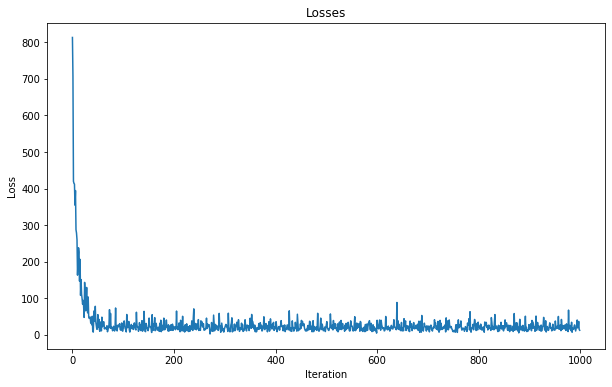

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1000)), losses)
plt.title("Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [16]:
def predict(x, weights):
    '''
    Generates predictions from the step by step linear model
    '''
    
    N = np.dot(x, weights['W'])
    P = N + weights['B']
    
    return P

In [17]:
preds = predict(x_test, weights)

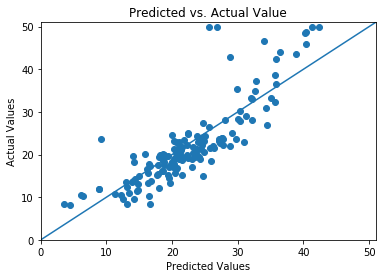

In [18]:
plt.title("Predicted vs. Actual Value")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])

In [19]:
def mean_absolute_error(preds, actuals):
    '''
    Compute mean absolute error
    '''
    return np.mean(np.abs(actuals - preds))

In [20]:
def root_mean_squared_error(pred, actual):
    '''
    Compute root mean squared error
    '''
    return np.sqrt(np.mean(np.power(actual - pred, 2)))

In [21]:
print(f"Mean absolute error:\n{mean_absolute_error(preds,y_test)}")
print()
print(f"Root mean squared error:\n{root_mean_squared_error(preds,y_test)}")

Mean absolute error:
3.5644381172615454

Root mean squared error:
5.049680281687752


In [22]:
np.mean(y_test)

22.07763157894737

In [23]:
ave_pred_error_percent = root_mean_squared_error(preds,y_test) / np.mean(y_test)
print(f"Average prediction error percent:\n{round(ave_pred_error_percent*100, 2)}%")

Average prediction error percent:
22.87%


In [24]:
np.round(weights['W'], 4)

array([[-1.0954],
       [ 0.7353],
       [ 0.1977],
       [ 0.7475],
       [-2.2849],
       [ 2.2006],
       [ 0.7195],
       [-2.6384],
       [ 2.5358],
       [-1.6892],
       [-2.3162],
       [ 0.8435],
       [-4.2553]])

In [25]:
'''NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]'''

num = 40

a = np.repeat(x_test[:,: -1].mean(axis=0, keepdims=True), num, axis=0) #shape is (40, 12)
b = np.linspace(-1.5, 3.5, num).reshape(40, 1) #shape is (40, 1)
test_feature = np.concatenate([a, b], axis=1)
test_predictions = predict(test_feature, weights)#.reshape(num)
x_val = test_feature[:,-1]
y_val = test_predictions[:,0]

(6, 51)

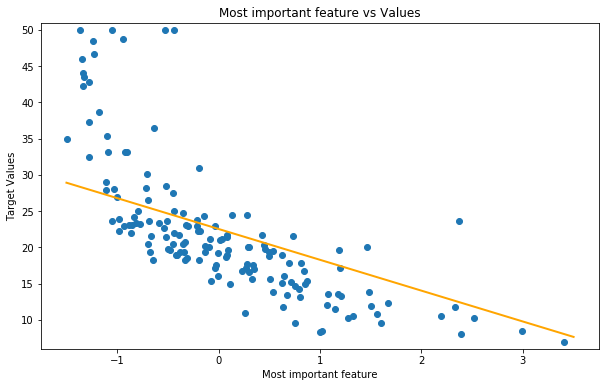

In [26]:
# x_test[:, n] returns an 1D array consisting of the nth element of every row
plt.figure(figsize=(10, 6))
plt.scatter(x_test[:, 12], y_test)
plt.plot(x_val, y_val, c='orange', lw=2)
plt.title("Most important feature vs Values")
plt.xlabel("Most important feature")
plt.ylabel("Target Values")
plt.ylim([6, 51])

In [27]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
a[:, 2]

array([3, 6, 9])